# Easy Data Science Project
## I have created this notebook as an example<br />The dataset is a structured "temperature-readings-iot-devices" dataset from Kaggle .

This is an example script where I work on the Kaggle IoT Dataset. It is a work in progress hobby project.
The challenge is that the IoT devices were "uninstalled or shut off several times during the entire reading period" which causes some irregularities in the data and unreliability (?) when it comes to generating some insights about weather and climate change.

by Mavi Nunn Polatoglu / July 2020

In [128]:
# import necessary packages
from io import BytesIO
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json

## Upload and Access Data

Uploaded the dataset into IBM Cloud as a resource. The data is accesses with the following.

In [129]:
# The code was removed by Watson Studio for sharing.

### Extract
The dataset is zipped, so it needs to be extracted.

In [130]:
zip_ref = zipfile.ZipFile(BytesIO(streaming_body_1.read()), 'r') # If you run this 2 times, there will be an error becuase it was already extracted or unzipped?
membernames = zip_ref.namelist()[0]
print(zip_ref.extract(zip_ref.infolist()[0], path=None, pwd=None))
mydata = zip_ref.extract(zip_ref.infolist()[0], path=None, pwd=None)
zip_ref.close()
df_data = pd.read_csv(mydata)
df_data.head()

/home/dsxuser/work/IOT-temp.csv


,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [131]:
print('Shape of the dataframe is ' +  str(df_data.shape))

Shape of the dataframe is (97606, 5)


## Cleaning Data and Checking for Non-Uniform Representations

### Check duplicates
Before anything checking if there are any duplicate rows.

In [132]:
df_data_2 = df_data.drop_duplicates(inplace = False)
if(df_data.shape != df_data_2.shape):
    print('What? Seriously? Thought the id column was unique.')

    rows = df_data[df_data.duplicated(keep = False)]
    print('The identical rows are:')
    print(rows.head())
    df_data.drop_duplicates(inplace = True)
    df_data.reset_index(inplace = True)
    
del(df_data_2) # no need for this?

print(df_data.shape)

What? Seriously? Thought the id column was unique.
The identical rows are:
                                     id  room_id/id        noted_date  temp  \
10  __export__.temp_log_196108_4a983c7e  Room Admin  08-12-2018 09:25    42   
11  __export__.temp_log_196108_4a983c7e  Room Admin  08-12-2018 09:25    42   

   out/in  
10    Out  
11    Out  
(97605, 6)


Removing uninformative data. It is said that room_id/i are all "Room Admin", so column totally not needed.

In [133]:
df_data.drop(['room_id/id'], axis = 1, inplace = True)

### Get rid of reoccuring non informative strings
Renaming columns because the recurring string in the id column is annoying.

In [134]:
df_data['id'] = df_data['id'].str.replace('__export__.temp_log_','')
df_data.drop('index', axis = 1, inplace = True, errors = 'ignore') # there is an extra column being created from the replace which I drop
df_data.head()

,id,noted_date,temp,out/in
0,196134_bd201015,08-12-2018 09:30,29,In
1,196131_7bca51bc,08-12-2018 09:30,29,In
2,196127_522915e3,08-12-2018 09:29,41,Out
3,196128_be0919cf,08-12-2018 09:29,41,Out
4,196126_d30b72fb,08-12-2018 09:29,31,In


### Change data type
Convert noted_date to datetime object, there are easy methods readily implemented for date/time objects.

In [135]:
df_data['noted_date'] = pd.to_datetime(df_data['noted_date'], errors='ignore')
print('For instance, for this: ' + str(df_data.iloc[0, 1]))
print('I can access the data side with \'.date()\' = ' + str(df_data.iloc[0, 1].date())) 
print('or time with \'.time()\' = ' + str(df_data.iloc[0, 1].time()))

# Separate the date and times
df_data['Date'] = df_data['noted_date'].dt.date
df_data['Day'] = df_data['noted_date'].dt.dayofweek
# df_data.drop(['noted_date'], axis = 1, inplace = True)
df_data.head()

For instance, for this: 2018-08-12 09:30:00
I can access the data side with '.date()' = 2018-08-12
or time with '.time()' = 09:30:00


,id,noted_date,temp,out/in,Date,Day
0,196134_bd201015,2018-08-12 09:30:00,29,In,2018-08-12,6
1,196131_7bca51bc,2018-08-12 09:30:00,29,In,2018-08-12,6
2,196127_522915e3,2018-08-12 09:29:00,41,Out,2018-08-12,6
3,196128_be0919cf,2018-08-12 09:29:00,41,Out,2018-08-12,6
4,196126_d30b72fb,2018-08-12 09:29:00,31,In,2018-08-12,6


### Check various representations
Temperature measurements are taken either indoors or outdoors. So, checking unique values to see if there are any differently written out/in values.

In [136]:
print(df_data['out/in'].unique())
if(len(df_data['out/in'].unique()) > 2):
    print('There are different representations!')       

['In' 'Out']


## Exploring any imbalanced that could cause biases.

It is known that the data is collected non-uniformly between 2018-07-28 and 2018-12-08. But is the data collected more on some days than others?\
If there is a big imbalance, it may be a problem because measurements from various days is more valuable.

**By the way, the given date range is wrong!**\
Took me sometime to realize...

In [137]:
oldest_date = min(df_data["Date"])
newest_date = max(df_data["Date"])
print('The date range is actually : ' + str(oldest_date) + ' to ' + str(newest_date))

The date range is actually : 2018-01-11 to 2018-12-10


### Check measurement distribution
How many measurements does a single day have? Are there some days that get more than others?\
Ideally every day should have measurements at similar times.

In [138]:
group_date = df_data.groupby(by='Date', axis = 0).count()
print('There are ' + str(len(df_data["Date"].unique())) +' unique dates in the dataset.')

alldates = pd.date_range(start = min(df_data["Date"]), end =max(df_data["Date"]), freq = "D")
print("The number of days in the defined period is: " + str(alldates.shape))

print('The minimum,maximum number of measurements within a single day is ' + str(group_date.describe().min()[0]) + ',' +str(group_date.describe().max()[0]))
group_date.describe()

There are 86 unique dates in the dataset.
The number of days in the defined period is: (334,)
The minimum,maximum number of measurements within a single day is 11.0,20564.0


,id,noted_date,temp,out/in,Day
count,86.00000,86.00000,86.00000,86.00000,86.00000
mean,1134.94186,1134.94186,1134.94186,1134.94186,1134.94186
std,2740.04481,2740.04481,2740.04481,2740.04481,2740.04481
min,11.00000,11.00000,11.00000,11.00000,11.00000
25%,254.75000,254.75000,254.75000,254.75000,254.75000
50%,424.00000,424.00000,424.00000,424.00000,424.00000
75%,631.25000,631.25000,631.25000,631.25000,631.25000
max,20564.00000,20564.00000,20564.00000,20564.00000,20564.00000


### Comments:
  
So, there are some days that get as little as 11 measurements while the mean is 1135. Also, from the discrepancy between 334 and 86, we can also conclude that some days lack measurements altogether.\
\
By analyzing the specific distribution of measurements with respect to date, one could have also classify the measurements depending on the season.\
Shame the location is not available because India has different seasons in different regions.

### Visualizing measurement distribution accross dates
accross whole measurement period

In [139]:
# Insert empty dates (days without datapoints) as Nans
print("The number of dates before adding empty dates: " + str(len(df_data["noted_date"].dt.date.unique())))
df_alldates = pd.DataFrame()
df_alldates["noted_date"] = alldates
not_dates = df_alldates.isin(df_data["Date"].unique())
insert_dates = df_alldates[np.logical_not(not_dates)["noted_date"]]
insert_dates = insert_dates.reindex(columns=list((df_data.columns.values.tolist())))
# insert_dates

forviz_df_data = pd.concat([df_data, insert_dates]) # input the missing dates with other elements Nan
forviz_df_data.reset_index(inplace = True, drop = True) 
print("The number of dates after adding empty dates: " + str(len(forviz_df_data["noted_date"].dt.date.unique())))

# Sort according to dates
forviz_df_data.sort_values(by = "noted_date", inplace = True) #, axis = 1, inplace = True)
forviz_df_data.reset_index(inplace = True, drop = True) 
forviz_df_data.head()
forviz_df_data['Date'] = forviz_df_data['noted_date'].dt.date # add dates into the Date column


The number of dates before adding empty dates: 86
The number of dates after adding empty dates: 334


Intentionally left the Nan values for the boxplot (The Nan values are not shown in the figure).

### Comments:
The measurements are very seldom until something like September! [Sorry the dates on the x-axis are not very visible]

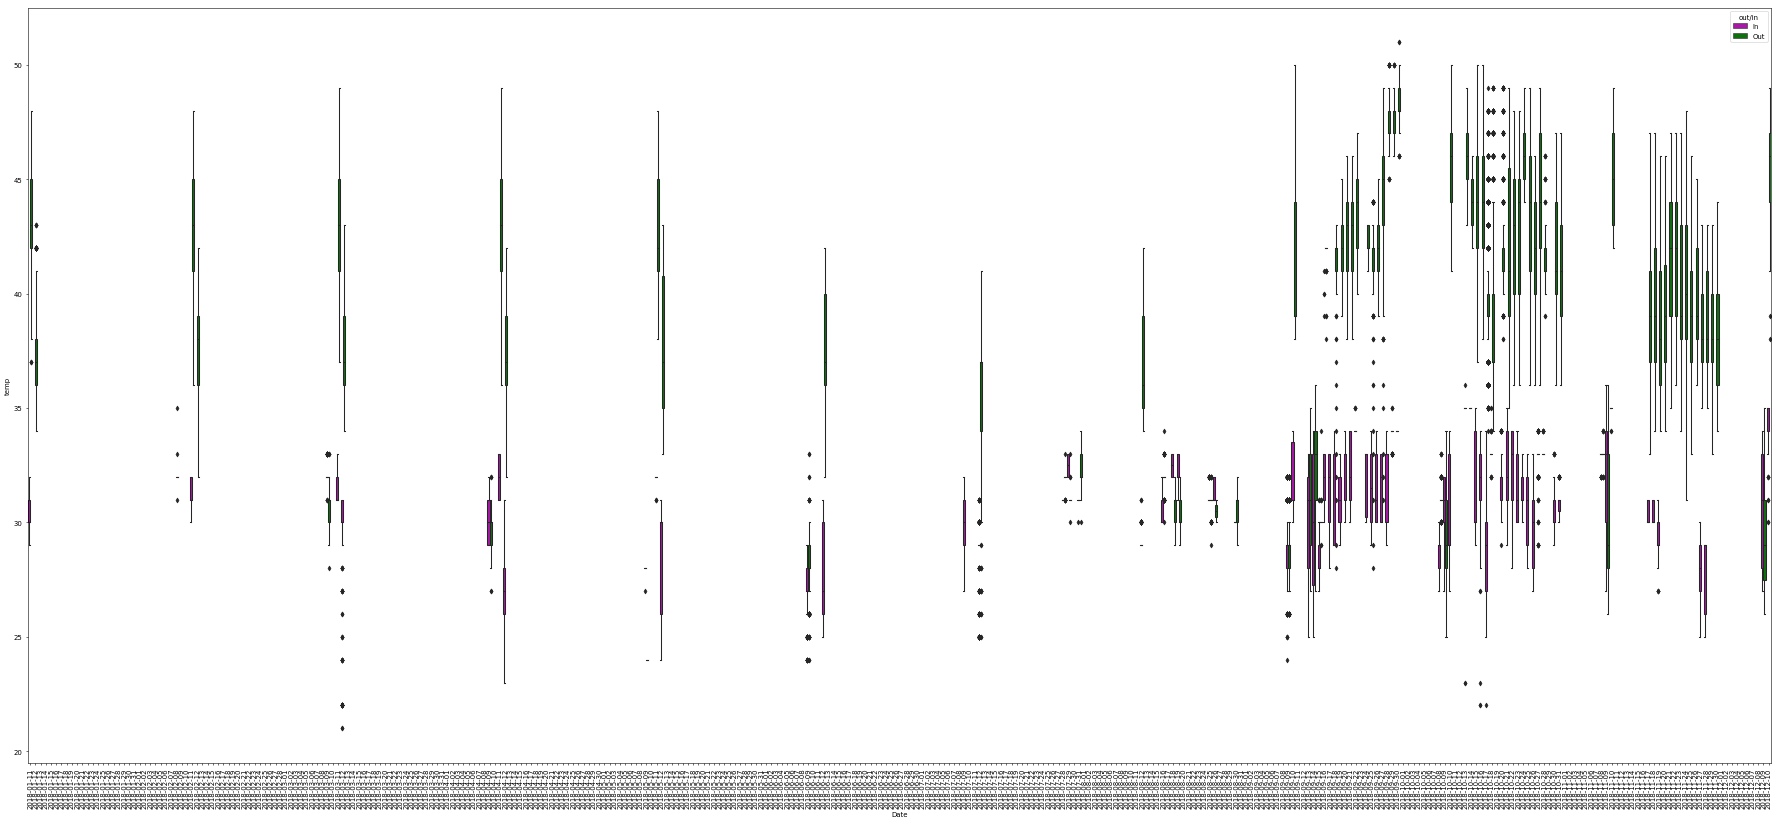

In [140]:
myfig = plt.figure(figsize=(45, 20), dpi= 50, facecolor='w', edgecolor='k')
myaxis = myfig.gca()

sns.boxplot(x="Date", y="temp",
            hue="out/in", palette=["m", "g"],
            data=forviz_df_data)

outtext = myaxis.set_xticklabels(myaxis.get_xticklabels(), rotation=90)

### Check day of week.

I want to see if there is workday/weekend related bias in the measurements.

In [141]:
group_day = df_data.groupby(by='Day', axis = 0).count()
group_day

,id,noted_date,temp,out/in,Date
Day,,,,,
0,8009,8009,8009,8009,8009
1,12874,12874,12874,12874,12874
2,24067,24067,24067,24067,24067
3,14170,14170,14170,14170,14170
4,16328,16328,16328,16328,16328
5,7094,7094,7094,7094,7094
6,15063,15063,15063,15063,15063


### Comments
It looks like Monday and saturday get less measurements. This could be because people are busy during those days?\
No action necessary at the moment.

### Check time of day.

I want to see if there is time of day related bias in the measurements.\
Morning:   06.00-12.00\
Afternoon: 12.00-18.00\
Evening:   18.00-00.00\
Night:     00.00-06.00

In [142]:
# Group the times into morning/afternoon/evening/night

df_data = df_data.assign(TimeTag=pd.cut(df_data['noted_date'].dt.hour,
                        [-1, 6, 12, 18, 24],
                        labels=['Night', 'Morning', 'Afternoon', 'Evening']))

group_sun = df_data.groupby(by='TimeTag', axis = 0).count()
group_sun

,id,noted_date,temp,out/in,Date,Day
TimeTag,,,,,,
Night,24058,24058,24058,24058,24058,24058
Morning,23331,23331,23331,23331,23331,23331
Afternoon,30761,30761,30761,30761,30761,30761
Evening,19455,19455,19455,19455,19455,19455


In [143]:
df_data.head()

,id,noted_date,temp,out/in,Date,Day,TimeTag
0,196134_bd201015,2018-08-12 09:30:00,29,In,2018-08-12,6,Morning
1,196131_7bca51bc,2018-08-12 09:30:00,29,In,2018-08-12,6,Morning
2,196127_522915e3,2018-08-12 09:29:00,41,Out,2018-08-12,6,Morning
3,196128_be0919cf,2018-08-12 09:29:00,41,Out,2018-08-12,6,Morning
4,196126_d30b72fb,2018-08-12 09:29:00,31,In,2018-08-12,6,Morning


### Comments
I may separate measurements depending on their time tag later.

### Check balance between indoor and outdoor measurements.

In [144]:
# Let's compare In/Out
group_inout = df_data.groupby(by='out/in', axis = 0).count()
group_inout

,id,noted_date,temp,Date,Day,TimeTag
out/in,,,,,,
In,20345,20345,20345,20345,20345,20345
Out,77260,77260,77260,77260,77260,77260


### Comments
There is more data collected outdoors. Ratio almost 1 to 4!

In [145]:
# I want to look at combinations of in/out and time
In =        (df_data['out/in'] == "In")
Out =       (df_data['out/in'] == "Out")
Night =     (df_data['TimeTag'] == "Night")
Morning =   (df_data['TimeTag'] == "Morning")
Afternoon = (df_data['TimeTag'] == "Afternoon")
Evening =   (df_data['TimeTag'] == "Evening")

df_inNnight = df_data[In & Night]
df_inNmorning = df_data[In & Morning]
df_inNafternoon = df_data[In & Afternoon]
df_inNevening = df_data[In & Evening]

df_outNnight = df_data[Out & Night]
df_outNmorning = df_data[Out & Morning]
df_outNafternoon = df_data[Out & Afternoon]
df_outNevening = df_data[Out & Evening]

combinations = np.zeros((8,))
combinations[0:8] = [df_inNnight.shape[0], df_inNmorning.shape[0], df_inNafternoon.shape[0], df_inNevening.shape[0], df_outNnight.shape[0], df_outNmorning.shape[0], df_outNafternoon.shape[0], df_outNevening.shape[0]]

#just checking
if(np.sum(combinations) != df_data.shape[0]):  # With this check I noticed a mistake that was done before and fixed it. The assign function requireed -1 for the bins instead of 0: [-1, 6, 12, 18, 24]
    print('something is wrong')
    

# print('Keep in mind the in/out ratio is alomst 1 to 4')
# print("indoors @night: " + str(combinations[0]))
# print("indoors @morning: " + str(combinations[1]))
# print("indoors @afternoon: " + str(combinations[2]))
# print("indoors @evening: " + str(combinations[3]))

# print("outdoors @night: " + str(combinations[4]))
# print("outdoors @morning: " + str(combinations[5]))
# print("outdoors @afternoon: " + str(combinations[6]))
# print("outdoors @evening: " + str(combinations[7]))

# print(combinations[4] / combinations[0])
# print(combinations[5] / combinations[1])
# print(combinations[6] / combinations[2])
# print(combinations[7] / combinations[3])


| Category / timeTag | Night | Morning | Afternoon | Evening |
|------|------|------|------|------|
|Indoors|   4860  |   7572  |   5786  |   2127  |
|Outdoors|  19198  |   15759  |   24975  |   17328  |
|Outoors/Indoors|  3.95  |   2.08  |   4.31  |   8.14  |

### Comments
From the graph generated in cell 30, it can be seen that there are temperature differences depending on whether the measurement was indoor or outdoor (purple vs. green).\
The outdoor temperature is usually higher.

Let's test: Whether the outdoor temperature "looked" higher because the outdoor measurements were taken more during the day (morning+afternoon).

In [146]:
print("DayTime / Whole Day for indoors:" + str(100*(combinations[2]+combinations[1]) / (combinations[0]+combinations[1]+combinations[2]+combinations[3])) + "%")
print("DayTime / Whole Day for outdoors:" + str(100*(combinations[6]+combinations[5]) / (combinations[4]+combinations[5]+combinations[6]+combinations[7])) + "%")

DayTime / Whole Day for indoors:65.65740968296879%
DayTime / Whole Day for outdoors:52.72327206834067%


### Comments
OK, so it turns out that the outdoor measurements are pretty balanced between morning+afternoon vs. evening+evening.

### Let's Concentrate on Outdoor
Fixing for outdoor temperature we can analyze measurements and see the time-of-day's effect.

In [147]:
# Drop indoor temperatures and assign TimeTags
indoor_indeces = df_data[df_data['out/in'] == 'In' ].index
df_outdoor_data =df_data.drop(indoor_indeces, inplace=False)

df_outdoor_data = df_outdoor_data.assign(TimeTag=pd.cut(df_outdoor_data['noted_date'].dt.hour,
                                                       [-1, 6, 12, 18, 24],
                                                       labels=['Night', 'Morning', 'Afternoon', 'Evening']))

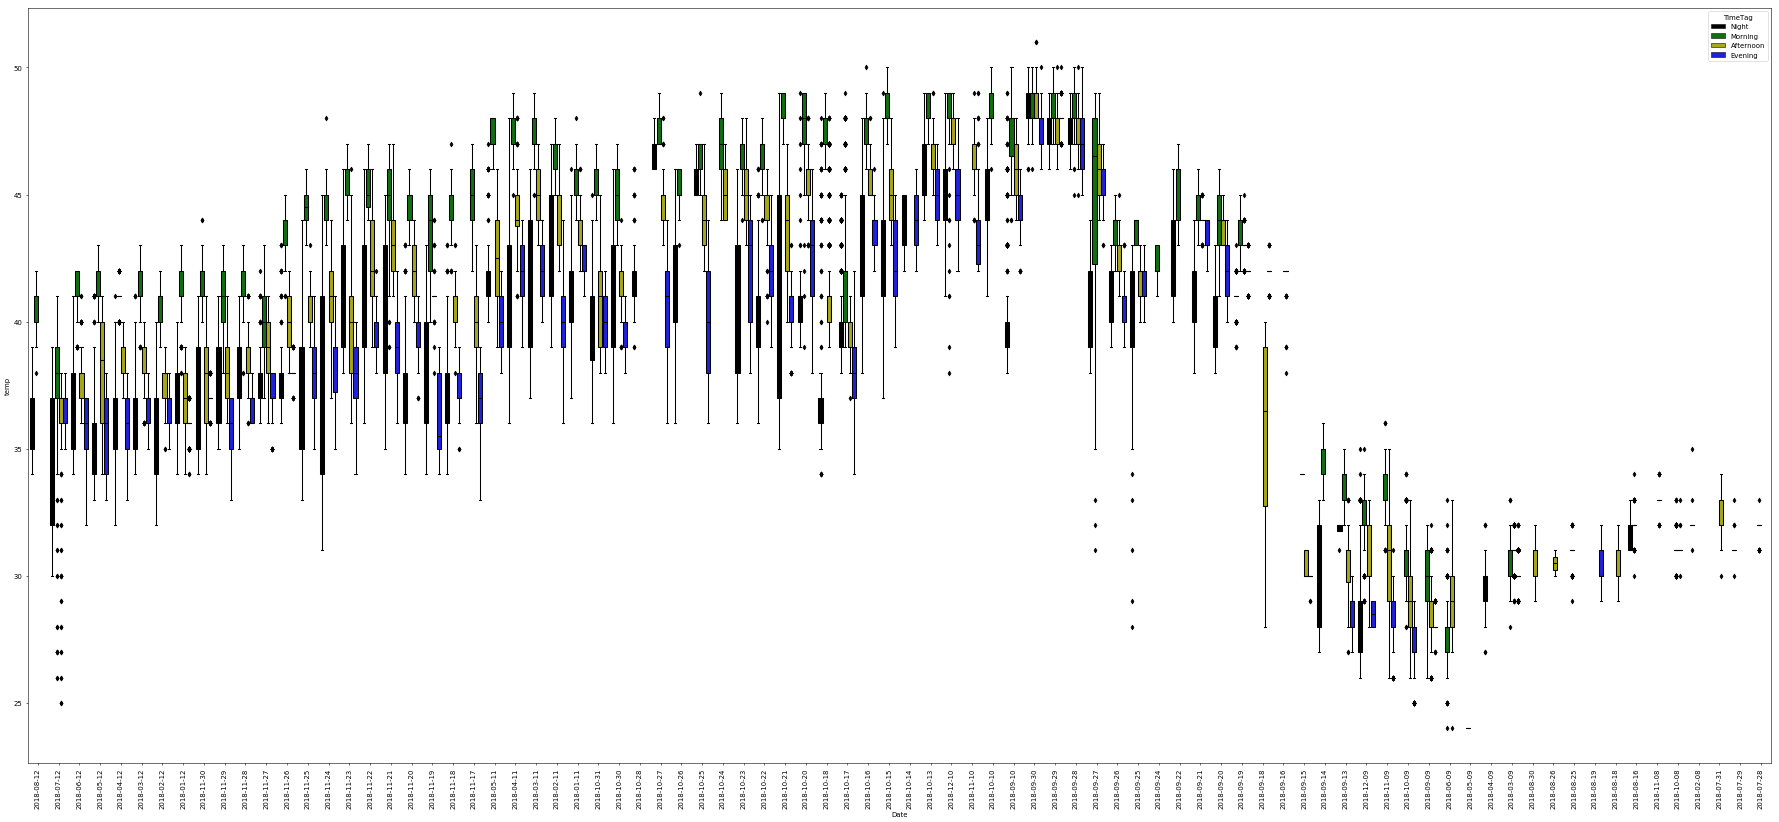

In [148]:
myfig = plt.figure(figsize=(45, 20), dpi= 50, facecolor='w', edgecolor='k')
myaxis = myfig.gca()

sns.boxplot(x="Date", y="temp",
            hue="TimeTag", palette=["k", "g", "y", "b"],
            data=df_outdoor_data)

outtext = myaxis.set_xticklabels(myaxis.get_xticklabels(), rotation=90)

### Comments
From the visualization I see that the hottest time of day is morning. (I thought it would have been afternoon actually?). Let's check some averages and deviations.

In [149]:
df_outdoor_temp = df_outdoor_data.drop(['id', 'noted_date', 'out/in', 'Date', 'Day'], axis = 1, inplace = False)
group_outdoor_temperatures = df_outdoor_temp.groupby(by='TimeTag', axis = 0).describe()
group_outdoor_temperatures

temp                                                   
             count       mean       std   min   25%   50%   75%   max
TimeTag                                                              
Night      19198.0  36.656943  4.978490  26.0  35.0  37.0  40.0  50.0
Morning    15759.0  37.661273  6.083273  24.0  32.0  40.0  42.0  50.0
Afternoon  24975.0  36.241081  5.771785  24.0  30.0  39.0  40.0  51.0
Evening    17328.0  34.596145  5.645916  25.0  28.0  37.0  39.0  50.0

### Let's see the indoor measurements.
I expect more constant measurements.

In [150]:
outdoor_indeces = df_data[df_data['out/in'] == 'Out' ].index
df_indoor_data =df_data.drop(outdoor_indeces, inplace=False)

df_indoor_data = df_indoor_data.assign(TimeTag=pd.cut(df_indoor_data['noted_date'].dt.hour,
                                                       [-1, 6, 12, 18, 24],
                                                       labels=['Night', 'Morning', 'Afternoon', 'Evening']))
df_indoor_temp = df_indoor_data.drop(['id', 'noted_date', 'out/in', 'Date', 'Day'], axis = 1, inplace = False)
group_indoor_temperatures = df_indoor_temp.groupby(by='TimeTag', axis = 0).describe()
group_indoor_temperatures

temp                                                   
            count       mean       std   min   25%   50%   75%   max
TimeTag                                                             
Night      4860.0  29.944444  2.163943  23.0  29.0  30.0  32.0  35.0
Morning    7572.0  30.758320  2.557120  21.0  29.0  31.0  32.0  36.0
Afternoon  5786.0  30.471656  1.705847  22.0  29.0  30.0  32.0  41.0
Evening    2127.0  30.486131  2.258603  25.0  29.0  30.0  32.0  36.0

As expected, the indoor temperatures are probably regulated since the standard deviation is not as high as outdoor measurements. Also, the temperatures are lower compared to the above table.

### Let's cross check with other datasets online.
Download temperature for 4 cities and save them as an asset in IBM Cloud

The dataset that I found belongs to 4 regions of India. There is a single measurement for each day though.
There are measurements from 1995 to 2020!

In [151]:
# data_bombay = pd.read_csv('http://academic.udayton.edu/kissock/http/Weather/gsod95-current/INBOMBAY.txt', delim_whitespace=True, names=('Month', 'Day', 'Year', 'Temp'))
# data_calcut = pd.read_csv('http://academic.udayton.edu/kissock/http/Weather/gsod95-current/INCALCUT.txt', delim_whitespace=True, names=('Month', 'Day', 'Year', 'Temp'))
# data_chenai = pd.read_csv('http://academic.udayton.edu/kissock/http/Weather/gsod95-current/INCHENAI.txt', delim_whitespace=True, names=('Month', 'Day', 'Year', 'Temp'))
# data_delhi =  pd.read_csv('http://academic.udayton.edu/kissock/http/Weather/gsod95-current/INDELHI.txt', delim_whitespace=True, names=('Month', 'Day', 'Year', 'Temp'))


# csv_submit = data_bombay.to_csv(index=False)
# csv_submit_2 = data_calcut.to_csv(index=False)
# csv_submit_3 = data_chenai.to_csv(index=False)
# csv_submit_4 = data_delhi.to_csv(index=False)

In [152]:
# The code was removed by Watson Studio for sharing.

In [236]:
# Import the data from IBM Cloud
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_2 = client_2a30065e7e504033ba65ae2f0fde94f4.get_object(Bucket='cleaningex1temperatureiot-donotdelete-pr-zywwvzlej2vofg', Key='data_bombay.csv')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_2, "__iter__"): streaming_body_2.__iter__ = types.MethodType( __iter__, streaming_body_2 )   
df_bombay = pd.read_csv(streaming_body_2, parse_dates=[[0, 1, 2]])
df_bombay.rename(columns={"Month_Day_Year": "Date"}, inplace = True)

streaming_body_3 = client_2a30065e7e504033ba65ae2f0fde94f4.get_object(Bucket='cleaningex1temperatureiot-donotdelete-pr-zywwvzlej2vofg', Key='data_calcut.csv')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_3, "__iter__"): streaming_body_3.__iter__ = types.MethodType( __iter__, streaming_body_3 )
df_calcut = pd.read_csv(streaming_body_3, parse_dates=[[0, 1, 2]])
df_calcut.rename(columns={"Month_Day_Year": "Date"}, inplace = True)

streaming_body_4 = client_2a30065e7e504033ba65ae2f0fde94f4.get_object(Bucket='cleaningex1temperatureiot-donotdelete-pr-zywwvzlej2vofg', Key='data_chenai.csv')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_4, "__iter__"): streaming_body_4.__iter__ = types.MethodType( __iter__, streaming_body_4 )
df_chenai = pd.read_csv(streaming_body_4, parse_dates=[[0, 1, 2]])
df_chenai.rename(columns={"Month_Day_Year": "Date"}, inplace = True)

streaming_body_5 = client_2a30065e7e504033ba65ae2f0fde94f4.get_object(Bucket='cleaningex1temperatureiot-donotdelete-pr-zywwvzlej2vofg', Key='data_delhi.csv')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_5, "__iter__"): streaming_body_5.__iter__ = types.MethodType( __iter__, streaming_body_5 )
df_delhi = pd.read_csv(streaming_body_5, parse_dates=[[0, 1, 2]])
df_delhi.rename(columns={"Month_Day_Year": "Date"}, inplace = True)

In [245]:
# Will compare the year 2018 with IoT.
drop_indeces = df_bombay[df_bombay['Date'].dt.year != 2018].index
df_bombay_2018 = df_bombay.drop(drop_indeces, inplace=False)

drop_indeces = df_calcut[df_calcut['Date'].dt.year != 2018].index
df_calcut_2018 = df_calcut.drop(drop_indeces, inplace=False)

drop_indeces = df_chenai[df_chenai['Date'].dt.year != 2018].index
df_chenai_2018 = df_chenai.drop(drop_indeces, inplace=False)

drop_indeces = df_delhi[df_delhi['Date'].dt.year != 2018].index
df_delhi_2018 = df_delhi.drop(drop_indeces, inplace=False)

frames = [df_bombay_2018, df_calcut_2018, df_chenai_2018, df_delhi_2018]
second_dataset = pd.concat(frames)

no_data_flag = second_dataset[second_dataset['Temp'] < -90].index # -99 was used as a no data flag
second_dataset.drop(no_data_flag, inplace=True)

second_dataset.reset_index(inplace = True, drop = True) 

In [243]:
# The second data has a temperature value for each day calculated by min+max/2.
first_dataset = df_outdoor_data.drop(['id', 'noted_date', 'out/in', 'Day', 'TimeTag'], axis = 1, inplace = False)
first_dataset.reset_index(inplace = True, drop = True)
max_first_dataset = first_dataset.groupby(by='Date', axis = 0).max()
min_first_dataset = first_dataset.groupby(by='Date', axis = 0).min()

av_first_dataset['temp'] = (min_first_dataset['temp'] + max_first_dataset['temp'])/2

av_first_dataset.head()

,temp
Date,
2018-01-11,42.5
2018-01-12,38.5
2018-02-08,33.0
2018-02-11,42.0
2018-02-12,37.0


In [246]:
# Oh! Of course. Fahrenheit to Celcius conversion.
second_dataset['Temp'] = second_dataset['Temp'].astype(np.float)
temp = np.round((np.asarray(second_dataset['Temp']) - 32) * (5/9), decimals = 1)
second_dataset['Temp'] = temp.astype(np.int64)
second_dataset.head(20)

,Date,Temp
0,2018-01-01,25
1,2018-01-02,24
2,2018-01-03,24
3,2018-01-05,25
4,2018-01-06,24
5,2018-01-07,23
6,2018-01-08,23
7,2018-01-09,25
8,2018-01-10,27
9,2018-01-11,27


Why are the values in these two datasets very different?
Things to check:
* are Bombay, Calcut, Chenai and Delhi unusually cold places in India?
* description of datasets